##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 Core API 进行二元分类的逻辑回归

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/core/logistic_regression_core"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/logistic_regression_core.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/logistic_regression_core.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/core/logistic_regression_core.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

本指南演示了如何使用 [TensorFlow Core 低级 API](https://tensorflow.google.cn/guide/core) 来执行[二元分类](https://developers.google.com/machine-learning/glossary#binary_classification){:.external}和[逻辑回归](https://developers.google.com/machine-learning/crash-course/logistic-regression/){:.external}。它使用 [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)){:.external} 进行肿瘤分类。

[逻辑回归](https://developers.google.com/machine-learning/crash-course/logistic-regression/){:.external}是最流行的二元分类算法之一。给定一组具有特征的样本，逻辑回归的目标是输出 0 到 1 之间的值，这可以解释为每个样本属于特定类的概率。 

## 安装

本教程使用 [pandas](https://pandas.pydata.org){:.external} 将 CSV 文件读入 [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html){:.external}，使用 [seaborn](https://seaborn.pydata.org){:.external} 在数据集中绘制成对关系，使用 [Scikit-learn](https://scikit-learn.org/){:.external} 计算混淆矩阵以及使用 [matplotlib](https://matplotlib.org/){:.external} 创建可视化效果。

In [2]:
!pip install -q seaborn

In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2023-11-07 17:55:19.372079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 17:55:19.372123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 17:55:19.373749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0-rc1


## 加载数据

接下来，从 [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/) {:.external}加载 [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)){:.external}。此数据集包含各种特征，例如肿瘤的半径、纹理和凹度。

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
            'concavity', 'concave_poinits', 'symmetry', 'fractal_dimension']
column_names = ['id', 'diagnosis']

for attr in ['mean', 'ste', 'largest']:
  for feature in features:
    column_names.append(feature + "_" + attr)

使用 [`pandas.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html){:.external} 将数据集读入 [DataFrame](){:.external}：

In [5]:
dataset = pd.read_csv(url, names=column_names)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         569 non-null    int64  
 1   diagnosis                  569 non-null    object 
 2   radius_mean                569 non-null    float64
 3   texture_mean               569 non-null    float64
 4   perimeter_mean             569 non-null    float64
 5   area_mean                  569 non-null    float64
 6   smoothness_mean            569 non-null    float64
 7   compactness_mean           569 non-null    float64
 8   concavity_mean             569 non-null    float64
 9   concave_poinits_mean       569 non-null    float64
 10  symmetry_mean              569 non-null    float64
 11  fractal_dimension_mean     569 non-null    float64
 12  radius_ste                 569 non-null    float64
 13  texture_ste                569 non-null    float64

显示前五行：

In [7]:
dataset.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_poinits_mean  \
0          0.11840           0.27760          0.3001               0.14710   
1          0.08474           0.07864          0.0869               0.07017   
2          0.10960           0.15990          0.1974               0.12790   
3          0.14250           0.28390          0.2414               0.10520   
4          0.10030           0.13280          0.1980               0.10430   

   ...  radius_largest  texture_largest  perimeter_largest  area_largest  \
0  ...           25.38            17.33             184.60        2019.0   
1  ...           24.99            23.41             158.80        1956.0   
2  ...           23.57            25.53             152.50        1709.0   
3  ...           14.91            26.50              98.87         567.7   
4  ...           22.54            16.67             152.20        1575.0   

   smoothness_largest  compactness_largest  concavity_largest  \
0              0.1622               0.6656             0.7119   
1              0.1238               0.1866             0.2416   
2              0.1444               0.4245             0.4504   
3              0.2098               0.8663             0.6869   
4              0.1374               0.2050             0.4000   

   concave_poinits_largest  symmetry_largest  fractal_dimension_largest  
0                   0.2654            0.4601                    0.11890  
1                   0.1860            0.2750                    0.08902  
2                   0.2430            0.3613                    0.08758  
3                   0.2575            0.6638                    0.17300  
4                   0.1625            0.2364                    0.07678  

[5 rows x 32 columns]

使用 [`pandas.DataFrame.sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html){:.external}、[`pandas.DataFrame.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html){:.external} 和 [`pandas.DataFrame.iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html){:.external} 将数据集拆分为训练集和测试集。确保从目标标签中分离特征。测试集用于评估模型对未见数据的泛化性。

In [8]:
train_dataset = dataset.sample(frac=0.75, random_state=1)

In [9]:
len(train_dataset)

427

In [10]:
test_dataset = dataset.drop(train_dataset.index)

In [11]:
len(test_dataset)

142

In [12]:
# The `id` column can be dropped since each row is unique
x_train, y_train = train_dataset.iloc[:, 2:], train_dataset.iloc[:, 1]
x_test, y_test = test_dataset.iloc[:, 2:], test_dataset.iloc[:, 1]

## 预处理数据

此数据集包含每个样本收集的 10 个肿瘤测量值中每一个的平均值、标准误差和最大值。`"diagnosis"` 目标列是分类变量，`'M'` 表示恶性肿瘤，`'B'` 表示良性肿瘤诊断。此列需要转换成数字二进制格式以进行模型训练。

[`pandas.Series.map`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html){:.external} 函数用于将二进制值映射到类别。

预处理完成后，还应使用 `tf.convert_to_tensor` 函数将数据集转换为张量。

In [13]:
y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

使用 [`seaborn.pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html){:.external} 查看训练集中几对基于均值的特征的联合分布，并观察它们与目标的关系：

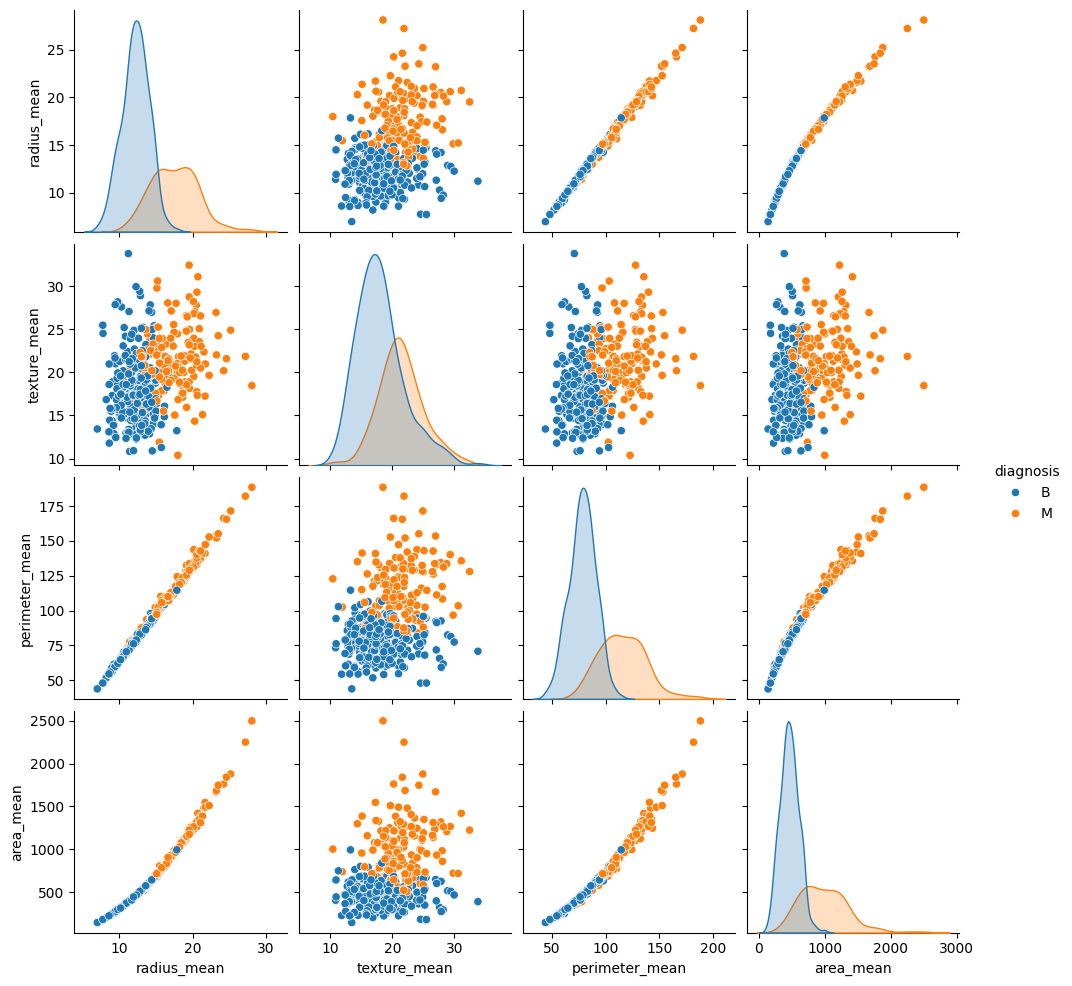

In [14]:
sns.pairplot(train_dataset.iloc[:, 1:6], hue = 'diagnosis', diag_kind='kde');

此变量关系组图表明，半径、周长和面积等某些特征高度相关联。这是意料之中的，因为肿瘤半径直接参与周长和面积的计算。此外，请注意，对于许多特征，恶性诊断似乎更偏右。

另外，确保查看一下总体统计信息。请注意每个特征覆盖大不相同的值范围。

In [15]:
train_dataset.describe().transpose()[:10]

count          mean           std         min  \
id                    427.0  2.756014e+07  1.162735e+08  8670.00000   
radius_mean           427.0  1.414331e+01  3.528717e+00     6.98100   
texture_mean          427.0  1.924468e+01  4.113131e+00    10.38000   
perimeter_mean        427.0  9.206759e+01  2.431431e+01    43.79000   
area_mean             427.0  6.563190e+02  3.489106e+02   143.50000   
smoothness_mean       427.0  9.633618e-02  1.436820e-02     0.05263   
compactness_mean      427.0  1.036597e-01  5.351893e-02     0.02344   
concavity_mean        427.0  8.833008e-02  7.965884e-02     0.00000   
concave_poinits_mean  427.0  4.872688e-02  3.853594e-02     0.00000   
symmetry_mean         427.0  1.804597e-01  2.637837e-02     0.12030   

                                25%           50%           75%           max  
id                    865427.500000  905539.00000  8.810829e+06  9.113205e+08  
radius_mean               11.695000      13.43000  1.594000e+01  2.811000e+01  
texture_mean              16.330000      18.84000  2.168000e+01  3.381000e+01  
perimeter_mean            75.235000      86.87000  1.060000e+02  1.885000e+02  
area_mean                420.050000     553.50000  7.908500e+02  2.499000e+03  
smoothness_mean            0.085850       0.09566  1.050000e-01  1.634000e-01  
compactness_mean           0.063515       0.09182  1.296500e-01  3.454000e-01  
concavity_mean             0.029570       0.05999  1.297500e-01  4.268000e-01  
concave_poinits_mean       0.019650       0.03390  7.409500e-02  2.012000e-01  
symmetry_mean              0.161700       0.17840  1.947000e-01  2.906000e-01

鉴于范围不一致，标准化数据以使每个特征具有零均值和单位方差是有利的。这个过程称为[归一化](https://developers.google.com/machine-learning/glossary#normalization){:.external}。

In [16]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

## 逻辑回归

在构建逻辑回归模型之前，务必了解此方法与传统线性回归的差异。

### 逻辑回归基础

线性回归返回其输入的线性组合；此输出无界限。[逻辑回归](https://developers.google.com/machine-learning/glossary#logistic_regression){:.external}的输出处于 `(0, 1)` 范围内。对于每个样本，它表示该样本属于*阳性*类的概率。

逻辑回归将传统线性回归的连续输出 `(-∞, ∞)` 映射到概率 `(0, 1)`。这种转换也是对称的，因此翻转线性输出的符号会得到原始概率的倒数。

让 $Y$ 表示属于第 `1` 类的概率（肿瘤是恶性的）。可以通过将线性回归输出解释为第 `1` 类与第 `0` 类的[对数优势](https://developers.google.com/machine-learning/glossary#log-odds){:.external}比来实现所需的映射：

$$\ln(\frac{Y}{1-Y}) = wX + b$$

通过设置 $wX + b = z$，此方程可以求解 $Y$：

$$Y = \frac{e^{z}}{1 + e^{z}} = \frac{1}{1 + e^{-z}}$$

表达式 $\frac{1}{1 + e^{-z}}$ 被称为 [sigmoid 函数](https://developers.google.com/machine-learning/glossary#sigmoid_function){:.external} $\sigma(z)$。因此，逻辑回归方程可以写为 $Y = \sigma(wX + b)$。

本教程中的数据集处理高维特征矩阵。因此，上述方程必须改写为矩阵向量形式：

$${\mathrm{Y}} = \sigma({\mathrm{X}}w + b)$$

其中：

- $\underset{m\times 1}{\mathrm{Y}}$：目标向量
- $\underset{m\times n}{\mathrm{X}}$：特征矩阵
- $\underset{n\times 1}w$：权重向量
- $b$：偏置项
- $\sigma$：应用于输出向量的每个元素的 sigmoid 函数

首先，呈现 sigmoid 函数，它将线性输出 `(-∞, ∞)` 转换为介于 `0` 和 `1` 之间。sigmoid 函数在 `tf.math.sigmoid` 中可用。

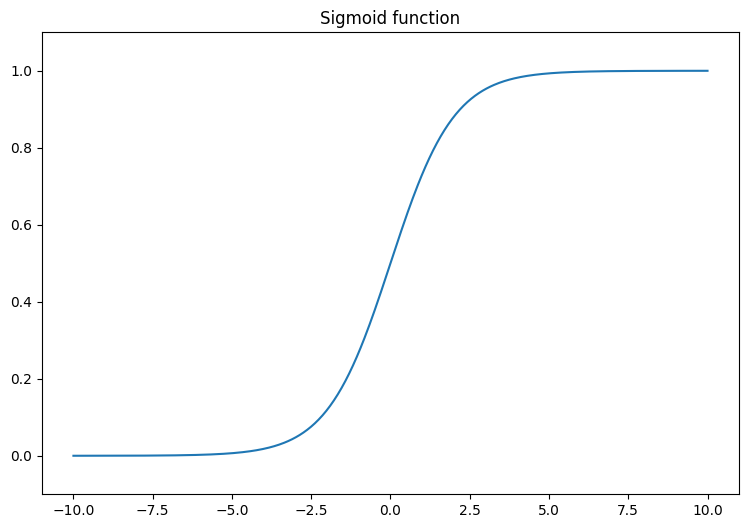

In [17]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

### 对数损失函数

[对数损失](https://developers.google.com/machine-learning/glossary#Log_Loss){:.external}（即二元交叉熵损失）是使用逻辑回归解决二元分类问题的理想损失函数。对于每个样本，对数损失量化了预测概率与样本真实值之间的相似度。它由以下方程确定：

$$L = -\frac{1}{m}\sum_{i=1}^{m}y_i\cdot\log(\hat{y}_i) + (1- y_i)\cdot\log(1 - \hat{y}_i)$$

其中：

- $\hat{y}$：预测概率向量
- $y$：真实目标向量

可以使用 `tf.nn.sigmoid_cross_entropy_with_logits` 函数计算对数损失。此函数自动将 sigmoid 激活应用于回归输出：

In [18]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

### 梯度下降更新规则

TensorFlow Core API 支持使用 `tf.GradientTape` 进行自动微分。如果您对逻辑回归[梯度更新](https://developers.google.com/machine-learning/glossary#gradient_descent){:.external}背后的数学感到好奇，下面是推导过程：

在上面的对数损失方程中，回顾一下，每个 $\hat{y}_i$ 可以根据输入重写为 $\sigma({\mathrm{X_i}}w + b)$。

The goal is to find a $w^*$ and $b^*$ that minimize the log loss:

$$L = -\frac{1}{m}\sum_{i=1}^{m}y_i\cdot\log(\sigma({\mathrm{X_i}}w + b)) + (1- y_i)\cdot\log(1 - \sigma({\mathrm{X_i}}w + b))$$

By taking the gradient $L$ with respect to $w$, you get the following:

$$\frac{\partial L}{\partial w} = \frac{1}{m}(\sigma({\mathrm{X}}w + b) - y)X$$

By taking the gradient $L$ with respect to $b$, you get the following:

$$\frac{\partial L}{\partial b} = \frac{1}{m}\sum_{i=1}^{m}\sigma({\mathrm{X_i}}w + b) - y_i$$

现在，构建逻辑回归模型。

In [19]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False
    
  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

要进行验证，确保未训练的模型为训练数据的一个小子集输出 `(0, 1)` 范围内的值。

In [20]:
log_reg = LogisticRegression()

In [21]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.9994985 , 0.9978607 , 0.29620072, 0.01979049, 0.3314926 ],
      dtype=float32)

接下来，编写一个准确率函数来计算训练期间正确分类的比例。为了从预测概率中检索分类，设置一个阈值，所有高于该阈值的概率都属于 1 类。这是一个可配置的超参数，默认设置为 0.5。

In [22]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

### 训练模型

使用 mini-batch 进行训练既可以提高内存效率，又能加快收敛速度​​。`tf.data.Dataset` API 具有用于批处理和重排的有用函数。借助该 API，您可以从简单、可重用的部分构建复杂的输入流水线。 

In [23]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

现在，为逻辑回归模型编写一个训练循环。该循环利用对数损失函数及其相对于输入的梯度来迭代更新模型的参数。

In [24]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.661


Epoch: 20, Training log loss: 0.418


Epoch: 40, Training log loss: 0.269


Epoch: 60, Training log loss: 0.178


Epoch: 80, Training log loss: 0.137


Epoch: 100, Training log loss: 0.116


Epoch: 120, Training log loss: 0.106


Epoch: 140, Training log loss: 0.096


Epoch: 160, Training log loss: 0.094


Epoch: 180, Training log loss: 0.089


### 性能评估

观察模型的损失和准确率随时间的变化。 

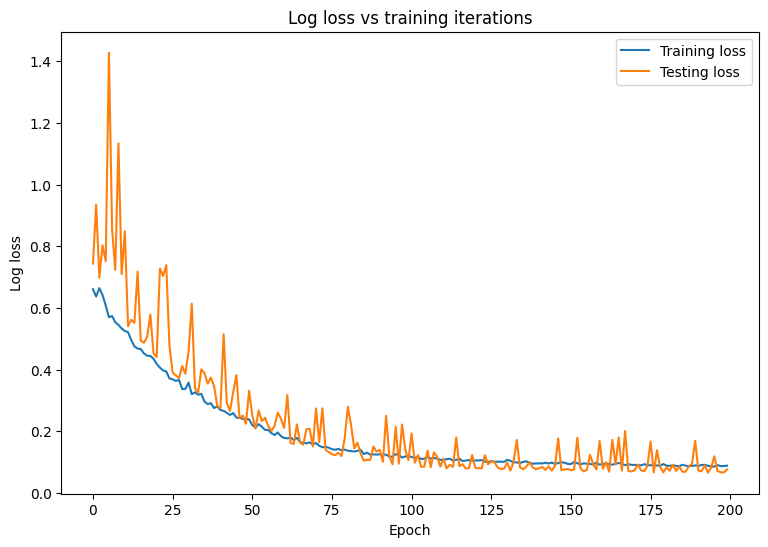

In [25]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

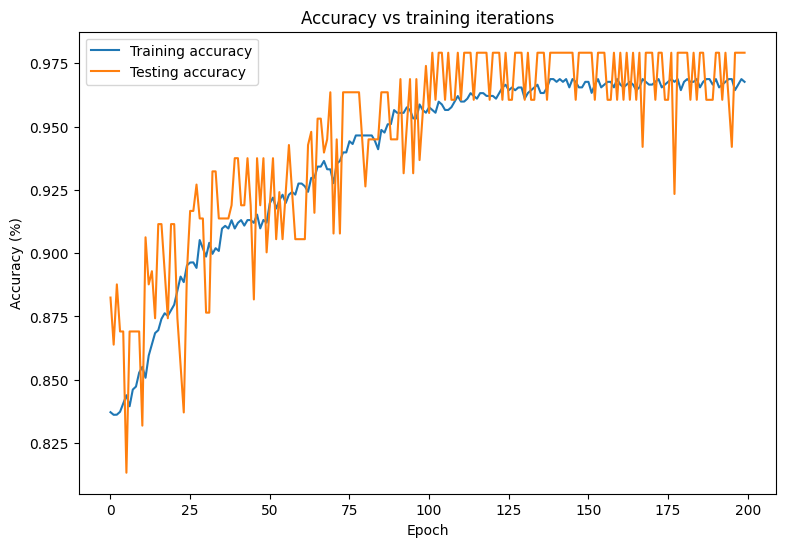

In [26]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [27]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.089
Final testing log Loss: 0.077


In [28]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.968
Final testing accuracy: 0.979


该模型在对训练数据集中的肿瘤进行分类方面表现出高准确率和低损失，并且可以很好地泛化到未知数据。更进一步，您可以探索错误率，从而在总体准确率分数之外提供更深入的见解。二元分类问题最常见的两种错误率是假阳性率 (FPR) 和假阴性率 (FNR)。

对于此问题，FPR 是恶性肿瘤预测在实际良性肿瘤中的比例。相反，FNR 是良性肿瘤预测在实际恶性肿瘤中的比例。

使用可评估分类的准确率的 [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix){:.external} 计算混淆矩阵，并使用 matplotlib 显示该矩阵：

In [29]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

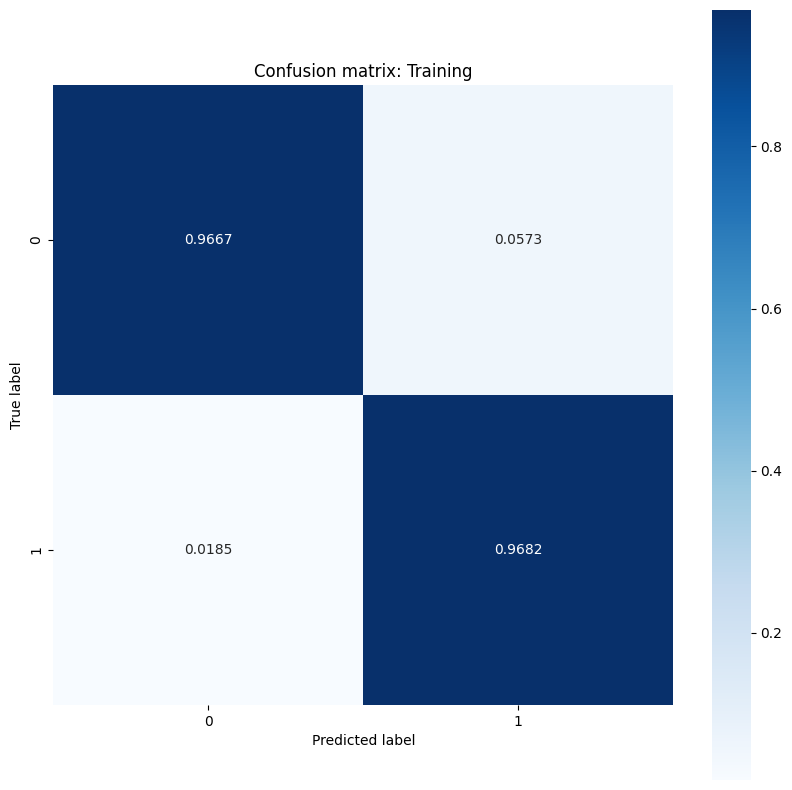

In [30]:
show_confusion_matrix(y_train, train_classes, 'Training')

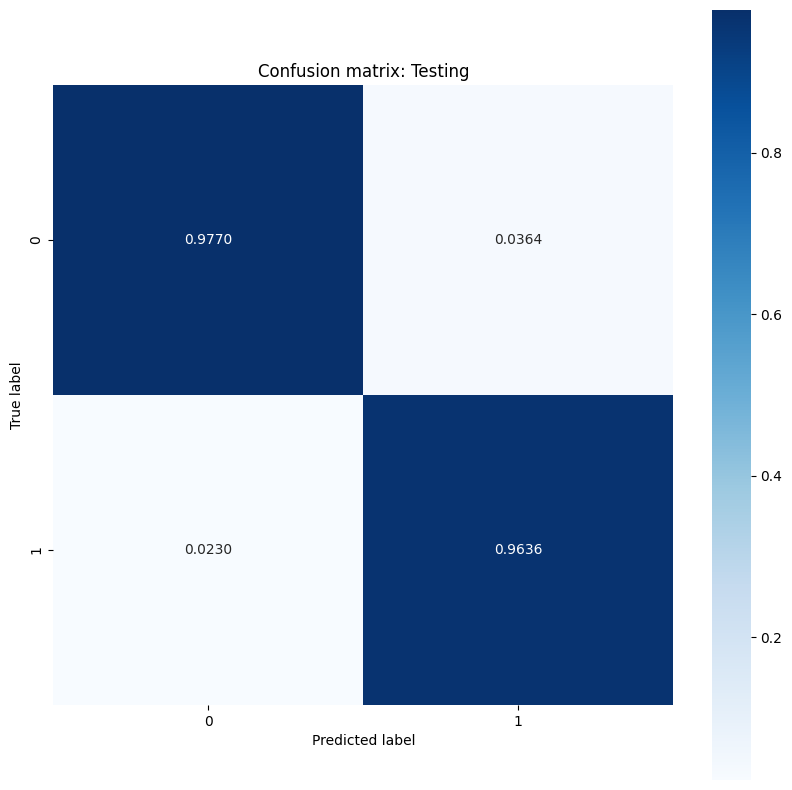

In [31]:
show_confusion_matrix(y_test, test_classes, 'Testing')

观察错误率测量值并在此示例的上下文中解释它们的重要性。在许多医学检测研究（例如癌症检测）中，使用高假阳性率来确保低假阴性率是完全可以接受的，实际上也是值得鼓励的，因为错过恶性肿瘤诊断（假阴性）的风险要比将良性肿瘤错误归类为恶性肿瘤（假阳性）严重得多。

为了控制 FPR 和 FNR，请尝试在对概率预测进行分类之前更改阈值超参数。较低的阈值会增加模型做出恶性肿瘤分类的总体几率。这不可避免地会增加假阳性的数量和 FPR，但它也有助于减少假阴性的数量和 FNR。

## 保存模型

首先，构建一个接受原始数据并执行以下运算的导出模块：

- 归一化
- 概率预测
- 类预测


In [32]:
class ExportModule(tf.Module):
  def __init__(self, model, norm_x, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.norm_x = norm_x
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    x = self.norm_x.norm(x)
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y 

In [33]:
log_reg_export = ExportModule(model=log_reg,
                              norm_x=norm_x,
                              class_pred=predict_class)

如果要将模型保存为当前状态，可以使用 `tf.saved_model.save` 函数完成。要加载保存的模型并进行预测，请使用 `tf.saved_model.load` 函数。

In [34]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpb1ti5a36/log_reg_export/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpb1ti5a36/log_reg_export/assets


In [35]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=float32)

## 结论

此笔记本介绍了处理逻辑回归问题的几种技术。下面是一些可能有所帮助的提示：

- [TensorFlow Core API](https://tensorflow.google.cn/guide/core) 可用于构建具有高度可配置性的机器学习工作流
- 分析错误率是一种良好的方法，可以让您更深入地了解分类模型在其总体准确率分数之外的性能。
- 过拟合是逻辑回归模型的常见问题，但本教程不存在此问题。有关这方面的更多帮助，请访问[过拟合与欠拟合](../../tutorials/keras/overfit_and_underfit.ipynb)教程。

有关使用 TensorFlow Core API 的更多示例，请查阅[教程](https://tensorflow.google.cn/guide/core)。如果您想详细了解如何加载和准备数据，请参阅有关[图像数据加载](../../load_data/images.ipynb)或 [CSV 数据加载](../../load_data/csv.ipynb)的教程。